In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import os

In [63]:
root_path = "/home/cdq/FedPet/log/agnews/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001"

data_point_list = [1, 2, 4, 8]
num_clients_infer_list = [5, 10, 15, 20] 
infer_freq_list = [1, 2, 4]




In [64]:
max_acc = []
df_main = pd.DataFrame(index = data_point_list, columns = pd.MultiIndex.from_product([num_clients_infer_list,
                                                    infer_freq_list]))

/home/cdq/FedPet/log/agnews/all_1000/seed_42/pattern_1/alpha_1_beta_0_gamma_0.001/new_all_aug_1_conver_0_limit_0_fedpet_64_32_roberta-base_5_1.log not exists
new_all_aug_1_conver_0_limit_0_fedpet_64_32_roberta-base_5_2.log
max accuracy is 0.8802631578947369, round is 63
new_all_aug_1_conver_0_limit_0_fedpet_64_32_roberta-base_5_4.log
max accuracy is 0.8538157894736842, round is 66
new_all_aug_1_conver_0_limit_0_fedpet_64_32_roberta-base_10_1.log
max accuracy is 0.8790789473684211, round is 50
new_all_aug_1_conver_0_limit_0_fedpet_64_32_roberta-base_10_2.log
max accuracy is 0.88, round is 50
new_all_aug_1_conver_0_limit_0_fedpet_64_32_roberta-base_10_4.log
max accuracy is 0.8725, round is 23
new_all_aug_1_conver_0_limit_0_fedpet_64_32_roberta-base_15_1.log
max accuracy is 0.8742105263157894, round is 52
new_all_aug_1_conver_0_limit_0_fedpet_64_32_roberta-base_15_2.log
max accuracy is 0.8711842105263158, round is 54
new_all_aug_1_conver_0_limit_0_fedpet_64_32_roberta-base_15_4.log
max ac

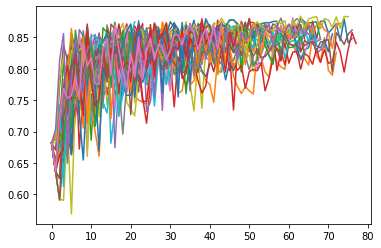

In [68]:
# round to accuracy
fig = plt.figure()
for data_point in data_point_list:
    for num_clients_infer in num_clients_infer_list:
        for infer_freq in infer_freq_list:
            filename = f"new_all_aug_{data_point}_conver_0_limit_0_fedpet_64_32_roberta-base_{num_clients_infer}_{infer_freq}.log"
            log_path = os.path.join(root_path, filename)
            if not os.path.exists(log_path):
                df_main.loc[data_point, num_clients_infer][infer_freq] = None
                print(f"{log_path} not exists")
                continue


            # plt.title(log_path)
            iter = 1000
            phrase = 'aggregated model performance is'
            with open(log_path) as f:
                f = f.readlines()
            df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
            for line in f:
                if phrase in line:
                    gen = int(re.findall(r'Gen (.+?) ',line)[0])
                    
                    acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                    df[0][gen]=acc

            df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
            if df.empty:
                print(f"Bug: {log_path}")

            print(filename)
            # print(df)
            this_max_acc = np.max(df[0])
            idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
            print(f"max accuracy is {this_max_acc}, round is {idx}")
            df_main.loc[data_point, num_clients_infer][infer_freq] = np.max(this_max_acc)

            # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
            iter = len(df.index)
            y_mean = []
            for j in range(iter):
                y = np.array(df.iloc[j])

                y_mean.append(pd.DataFrame(y).dropna().mean())
                # plt.scatter(j, y)
                    
            plt.plot(range(iter),y_mean)
            # fig.savefig(f"../fig/augment-yelp-{filename}.pdf")

In [66]:
df_main.to_csv("../data/NK.csv")

In [67]:
df_main

5                             10                            15  \
          1         2         4         1         2         4         1   
1      None  0.880263  0.853816  0.879079      0.88    0.8725  0.874211   
2  0.875263  0.874605    0.8575  0.866711  0.873947  0.880658  0.870132   
4  0.871316  0.864211  0.861579  0.866711  0.872895  0.883553  0.856711   
8  0.866974     0.855  0.858816  0.834868  0.874737  0.879474  0.864079   

                             20                      
          2         4         1         2         4  
1  0.871184  0.880526  0.859342  0.868947  0.865921  
2  0.873816  0.870526  0.877237  0.857895     0.865  
4  0.876316  0.873158  0.862105  0.871053  0.871579  
8  0.865132  0.879605  0.855921  0.870921  0.872237

In [ ]:
# time to accuracy
fig = plt.figure()
for data_point in data_point_list:
    for num_clients_infer in num_clients_infer_list:
        for infer_freq in infer_freq_list:
            filename = f"new_all_aug_{data_point}_conver_0_limit_0_fedpet_64_32_roberta-base_{num_clients_infer}_{infer_freq}.log"
            log_path = os.path.join(root_path, filename)
            if not os.path.exists(log_path):
                df_main.loc[data_point, num_clients_infer][infer_freq] = None
                print(f"{log_path} not exists")
                continue


            # plt.title(log_path)
            iter = 1000
            phrase = 'aggregated model performance is'
            with open(log_path) as f:
                f = f.readlines()
            df = pd.DataFrame(data=None, index = range(iter), columns = range(1))
            for line in f:
                if phrase in line:
                    gen = int(re.findall(r'Gen (.+?) ',line)[0])
                    
                    acc = float(re.findall(r': ?(\d+\.\d+)',line)[0])
                    df[0][gen]=acc

            df = df.dropna(axis=0, how='any') # any 只要有 nan 就会删掉。 all　是必须全是nan才删除; 0: 行；1：列
            if df.empty:
                print(f"Bug: {log_path}")

            print(filename)
            # print(df)
            this_max_acc = np.max(df[0])
            idx = [df[0].to_list().index(x) for x in df[0] if x == this_max_acc][0]
            print(f"max accuracy is {this_max_acc}, round is {idx}")
            df_main.loc[data_point, num_clients_infer][infer_freq] = np.max(this_max_acc)

            # df.to_csv("/Users/cdq/Desktop/opensource/FedPrompt/data/softlabel/agnews_aug_fedpet_128_32_roberta-large.csv")
            iter = len(df.index)
            y_mean = []
            for j in range(iter):
                y = np.array(df.iloc[j])

                y_mean.append(pd.DataFrame(y).dropna().mean())
                # plt.scatter(j, y)
                    
            plt.plot(range(iter),y_mean)
            # fig.savefig(f"../fig/augment-yelp-{filename}.pdf")